In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn, rho_A_t_fn, cum_A_t_fn)
import corner
from scipy.integrate import trapezoid as trapz

# data

In [2]:
exp_df = pd.read_csv('../outExp.csv')

count = ((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3)).sum()
print("Number of rows where RTwrtStim is NaN and abort_event == 3:", count)


exp_df = exp_df[~((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3))].copy()

exp_df_batch = exp_df[
    (exp_df['batch_name'] == 'Comparable') &
    (exp_df['LED_trial'].isin([np.nan, 0]))
]

df_valid_and_aborts = exp_df_batch[
    (exp_df_batch['success'].isin([1,-1])) |
    (exp_df_batch['abort_event'] == 3)
].copy()

# 1 is right , -1 is left
df_valid_and_aborts['choice'] = df_valid_and_aborts['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df_valid_and_aborts['accuracy'] = (df_valid_and_aborts['ILD'] * df_valid_and_aborts['choice']).apply(lambda x: 1 if x > 0 else 0)

df_aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]
# find ABL and ILD
ABL_arr = df_valid_and_aborts['ABL'].unique()
ILD_arr = df_valid_and_aborts['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

Number of rows where RTwrtStim is NaN and abort_event == 3: 16
ABL: [10 25 40 50 55 70]
ILD: [-8.   -4.   -2.25 -1.25 -0.5   0.    0.5   1.25  2.25  4.    8.  ]


# LED on or off

# VBMC

In [3]:
T_trunc = 0.3

## likelihood

In [4]:
def compute_loglike(row, V_A, theta_A, t_A_aff, pdf_trunc_factor):
    t_stim = row['intended_fix']
    rt = row['TotalFixTime']

    if rt < T_trunc:
        likelihood = 0
    else:
        if rt < t_stim:
            likelihood =  rho_A_t_fn(rt - t_A_aff, V_A, theta_A) / pdf_trunc_factor
        elif rt > t_stim:
            if t_stim <= T_trunc:
                likelihood = 1
            else:
                likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) ) / pdf_trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, V_A, theta_A)
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A, theta_A, t_A_aff, pdf_trunc_factor) \
                                       for _, row in df_valid_and_aborts.iterrows()  )
                                   


    loglike = np.sum(all_loglike)
    return loglike

## bounds

In [5]:
V_A_bounds = [0.1, 10]
theta_A_bounds = [0.1, 10]
t_A_aff_bounds = [-5, 0.1]

V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [-2, 0.06]

## prior

In [6]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A,t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

## prior + likelihood

In [7]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

## run vbmc

In [8]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, t_A_aff_0])


In [9]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -523867.829 +/-0.051.


## save

In [ ]:
# vp.save(f'trunc_and_censor_fit_aborts_LED_{LED_TRIAL}.pkl', overwrite=True)

In [ ]:
# import pickle
# with open('LED_OFF_VBMC_LT_RC_VP_DATA_0.pkl', 'rb') as f:
#     vp = pickle.load(f)

# Diagnostics

## corner

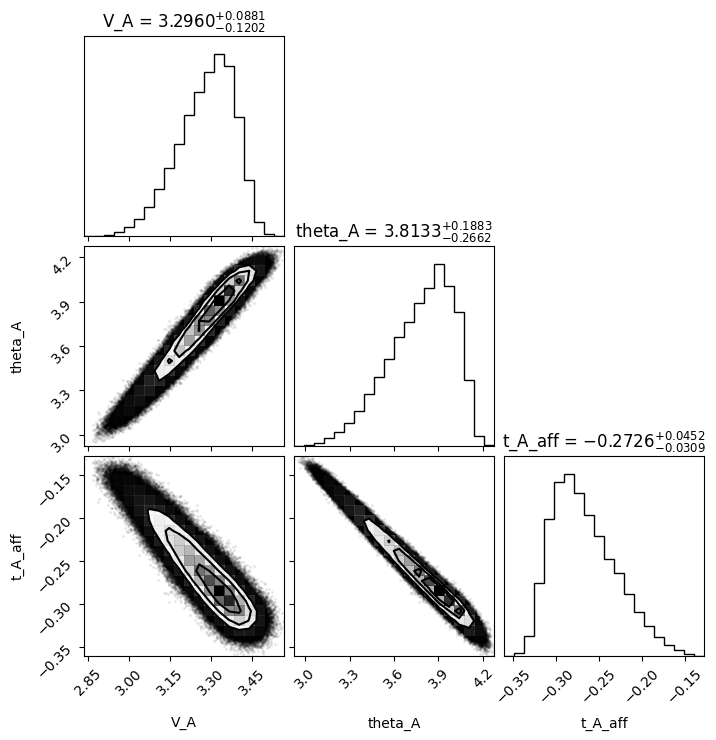

In [10]:
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f" );


In [11]:
V_A = vp_samples[:,0].mean()
theta_A = vp_samples[:,1].mean()
t_A_aff = vp_samples[:,2].mean()


print(f'V_A: {V_A}')
print(f'theta_A: {theta_A}')
print(f't_A_aff: {t_A_aff}')

V_A: 3.2822818913584815
theta_A: 3.779913210776598
t_A_aff: -0.26674662862584525


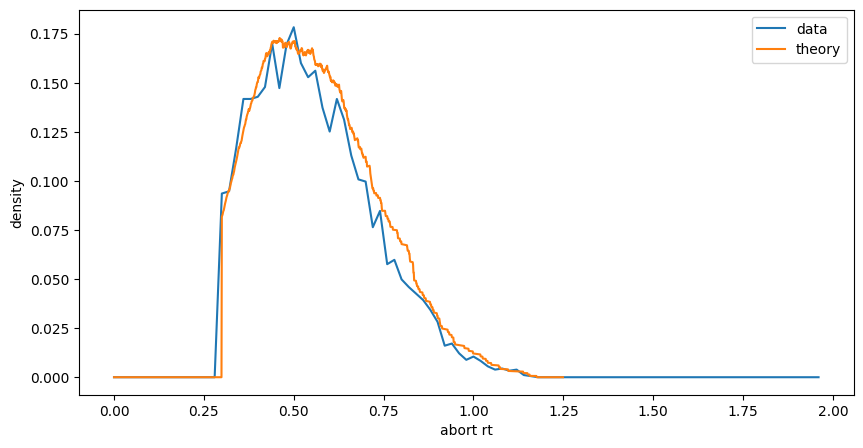

In [15]:


N_theory = int(1e3)
t_pts = np.arange(0,1.25, 0.001)
t_stim_samples = df_valid_and_aborts.sample(N_theory)['intended_fix']
pdf_samples = np.zeros((N_theory, len(t_pts)))

proactive_trunc_time = T_trunc

for i, t_stim in enumerate(t_stim_samples):
    t_stim_idx = np.searchsorted(t_pts, t_stim)
    proactive_trunc_idx = np.searchsorted(t_pts, proactive_trunc_time)
    pdf_samples[i, :proactive_trunc_idx] = 0
    pdf_samples[i, t_stim_idx:] = 0
    t_btn = t_pts[proactive_trunc_idx:t_stim_idx-1]
    
    pdf_samples[i, proactive_trunc_idx:t_stim_idx-1] = rho_A_t_VEC_fn(t_btn - t_A_aff, V_A, theta_A) / (1 - cum_A_t_fn(proactive_trunc_time - t_A_aff, V_A, theta_A))



plt.figure(figsize=(10,5))

bins = np.arange(0,2,0.02)
df_aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]
df_aborts_RT = df_aborts['TotalFixTime'].dropna().values
df_aborts_RT_trunc = df_aborts_RT[df_aborts_RT > proactive_trunc_time]

frac_aborts = len(df_aborts_RT_trunc) / len(df_valid_and_aborts)
aborts_hist, _ = np.histogram(df_aborts_RT_trunc, bins=bins, density=True)

plt.plot(bins[:-1], aborts_hist * frac_aborts, label='data')
plt.xlabel('abort rt')
plt.ylabel('density')

plt.plot(t_pts, np.mean(pdf_samples, axis=0), label='theory')
plt.legend()

# fit and see

In [ ]:
# plotting params

bw_data = 0.05
bins_data = np.arange(0, 2, bw_data)
t_pts_data = bins_data[:-1] + bw_data/2


bw_theory = 0.01
bins_theory = np.arange(0, 2, bw_theory)
t_pts_theory  = bins_theory[:-1] + bw_theory/2



# data aborts

In [ ]:
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values
frac_of_aborts = len(data_abort_rt)/len(df_to_fit)
print(f'frac of aborts: {frac_of_aborts}')

# trunc pdf abort fn

In [ ]:
# theory
def pdf_abort_trunc_fn(t, t_stim, V_A, theta_A, t_A_aff, trunc_factor):
    if t <= T_trunc or t >= t_stim:
        pdf = 0
    else:
        pdf = rho_A_t_fn(t - t_A_aff, V_A, theta_A) / trunc_factor

    return pdf

## sample t_stim and calc pdf for each t_stim

In [ ]:
V_A_samp_mean = np.mean(V_A_samp); theta_A_samp_mean = np.mean(theta_A_samp); t_A_aff_samp_mean = np.mean(t_A_aff_samp)


M = 50000
t_stim_all = df_to_fit['intended_fix'].values
t_stim_sample = random.choices(t_stim_all, k=M)


pdf_theory = np.zeros((M, len(t_pts_theory)))
cdf_theory = np.zeros((M,))
area_pdf_theory = np.zeros((M,))

trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_samp_mean, V_A_samp_mean, theta_A_samp_mean)

for i,t_stim in tqdm(enumerate(t_stim_sample)):
    pdf_theory[i, :] = [pdf_abort_trunc_fn(t, t_stim, V_A_samp_mean, theta_A_samp_mean, t_A_aff_samp_mean, trunc_factor) for t in t_pts_theory]
    cdf_theory[i] = cum_A_t_fn(t_stim - t_A_aff_samp_mean, V_A_samp_mean, theta_A_samp_mean) / trunc_factor
    area_pdf_theory[i] = trapz(pdf_theory[i, :], t_pts_theory)

# checks - area of pdf, area of aborts

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(area_pdf_theory, bins=50, density=True, alpha=0.5, label='theory')
area_pdf_theory_mean = np.mean(area_pdf_theory)
plt.axvline(area_pdf_theory_mean, color='r', label='pdf theory mean')
plt.axvline(frac_of_aborts, color='g', label='data aborts')
plt.title(f'trapz area under pdf. mean = {area_pdf_theory_mean:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cdf_theory, bins=50, density=True, alpha=0.5, label='theory')
cdf_theory_mean = np.mean(cdf_theory)
plt.title(f'cdf till t_stim, mean = {cdf_theory_mean:.4f}')
plt.axvline(cdf_theory_mean, color='r', label='cdf theory mean')
plt.axvline(frac_of_aborts, color='g', label='data aborts')
plt.legend()

# compare theory with data

In [ ]:
data_hist, _ = np.histogram(data_abort_rt, bins=bins_data, density=True)
data_hist *= frac_of_aborts

# theory
pdf_theory_mean = np.mean(pdf_theory, axis=0)

plt.step(t_pts_data, data_hist, label='data', color='b')
plt.plot(t_pts_theory, pdf_theory_mean, label='theory', color='r')
plt.legend()

plt.xlabel('abort time'); plt.ylabel('density')
plt.title(f'LED OFF, LTRC, area theory={trapz(pdf_theory_mean, t_pts_theory):.3f}, area data =  {trapz(data_hist, t_pts_data):.3f}')
